In [11]:
from keras.applications.vgg16 import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))


In [12]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [2]:
import os
import numpy as np
%env SM_FRAMEWORK=tf.keras





env: SM_FRAMEWORK=tf.keras


In [5]:
from keras.preprocessing.image import ImageDataGenerator

In [54]:
import os
print('total training yes images:', len(os.listdir('C:/Users/Ylan/Desktop/2021 Q3/IW-photo1/train/yes')))
print('total training no images:', len(os.listdir('C:/Users/Ylan/Desktop/2021 Q3/IW-photo1/train/no')))
print('total validation yes images:', len(os.listdir('C:/Users/Ylan/Desktop/2021 Q3/IW-photo1/validation/yes')))
print('total validation no images:', len(os.listdir('C:/Users/Ylan/Desktop/2021 Q3/IW-photo1/validation/no')))
print('total test yes images:', len(os.listdir('C:/Users/Ylan/Desktop/2021 Q3/IW-photo1/test/yes')))
print('total test no images:', len(os.listdir('C:/Users/Ylan/Desktop/2021 Q3/IW-photo1/test/no')))

total training yes images: 60
total training no images: 60
total validation yes images: 20
total validation no images: 20
total test yes images: 20
total test no images: 20


In [55]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'C:/Users/Ylan/Desktop/2021 Q3/IW-photo1'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 10

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 120)
validation_features, validation_labels = extract_features(validation_dir, 20)
test_features, test_labels = extract_features(test_dir, 20)

Found 120 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [56]:
train_features = np.reshape(train_features, (120, 7 * 7 * 512))
validation_features = np.reshape(validation_features, (20, 7 * 7 * 512))
test_features = np.reshape(test_features, (20, 7 * 7 * 512))

In [23]:
%env SM_FRAMEWORK=tf.keras


env: SM_FRAMEWORK=tf.keras


In [25]:
from tensorflow.keras import models




In [26]:
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

In [57]:
model = models.Sequential()
model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(5e-5), 
                       activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))


In [58]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=50,
                    batch_size=10,
                    validation_data=(validation_features, validation_labels))

Epoch 1/50
12/12 [==============================] - 2s 118ms/step - loss: 0.8021 - acc: 0.5417 - val_loss: 0.5826 - val_acc: 0.8000
Epoch 2/50
12/12 [==============================] - 1s 113ms/step - loss: 0.5368 - acc: 0.7500 - val_loss: 0.5046 - val_acc: 0.9000
Epoch 3/50
12/12 [==============================] - 1s 110ms/step - loss: 0.3730 - acc: 0.8500 - val_loss: 0.4453 - val_acc: 0.9000
Epoch 4/50
12/12 [==============================] - 1s 110ms/step - loss: 0.2797 - acc: 0.9417 - val_loss: 0.3839 - val_acc: 0.8500
Epoch 5/50
12/12 [==============================] - 1s 111ms/step - loss: 0.2383 - acc: 0.9583 - val_loss: 0.4126 - val_acc: 0.9000
Epoch 6/50
12/12 [==============================] - 1s 111ms/step - loss: 0.2042 - acc: 0.9667 - val_loss: 0.3505 - val_acc: 0.9000
Epoch 7/50
12/12 [==============================] - 2s 127ms/step - loss: 0.1852 - acc: 0.9583 - val_loss: 0.3228 - val_acc: 0.9000
Epoch 8/50
12/12 [==============================] - 1s 113ms/step - loss: 0.

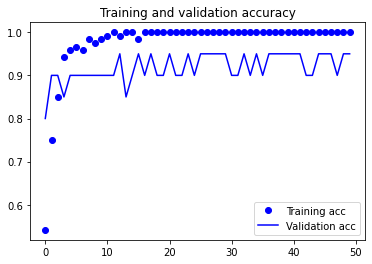

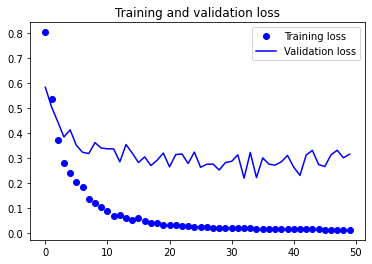

In [59]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [60]:
test_loss, test_acc = model.evaluate(test_features, test_labels)

1/1 [==============================] - 0s 94ms/step - loss: 0.2076 - acc: 0.9000


In [77]:
pred = model.predict(test_features).flatten()

In [78]:
pred

array([6.3431362e-05, 4.8346615e-01, 4.7747791e-03, 9.9999797e-01,
       9.9999583e-01, 9.9999976e-01, 9.9995565e-01, 9.9999106e-01,
       9.5695364e-01, 9.9669659e-01, 5.5184960e-04, 9.9998868e-01,
       1.7201841e-02, 9.9998856e-01, 2.3716688e-04, 1.6876277e-06,
       1.3496825e-06, 2.5057450e-05, 1.3652444e-04, 9.9794430e-01],
      dtype=float32)

In [71]:
import tensorflow as tf

In [79]:
predictions = tf.nn.sigmoid(pred)


In [80]:
predictions = tf.where(pred < 0.5, 0, 1)

In [81]:
print('Predictions:\n', predictions.numpy())
print('Labels:\n', test_labels)

Predictions:
 [0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 1]
Labels:
 [0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1.]


In [82]:
from sklearn.metrics import classification_report

print(classification_report(predictions, test_labels))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.90      0.90      0.90        10

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20

